## **Project1 - 商品特徵分群 (Clustering: PCA + KMeans)**

### **動機**

在量化交易策略開發中，若僅使用單一商品資料訓練模型，容易因「特定商品特徵」導致過度擬合 (Overfitting)。  
透過對多種商品（如貨幣對、黃金、原油、指數等）進行分群，可以將性質相似的商品歸為同一組，讓模型能在「同質性更高」的資料群上訓練，提高泛化能力、降低單一商品噪訊影響。  
本專案目的是：利用 PCA（主成分分析）與 KMeans 演算法，將 29 種商品按照其特徵相似度分群，為後續模型訓練提供可共用的資料集。

---

### **流程概述**

1. **讀取與預處理原始價格資料**  
   - 載入 27 種商品的歷史價格資料，包含：貨幣對（如 EURUSD、USDJPY）、貴金屬（如 XAUUSD、XAGUSD）、能源商品（如 原油）、指數類（如 SPX、DAX）等。  
   - 統一欄位名稱與時間索引格式，確保後續處理一致性。

2. **Dollar Bars 生成**  
   - 以固定交易量或金額（Dollar Volume）作為 Bar 的切割基準，生成 Dollar Bars。相較於固定時間長度 (Time Bars)，Dollar Bars 能更穩定地反映市場流動與成交密度。  
   - 針對每個商品，先計算累積成交金額達到固定閾值時所對應的 Bar，並輸出該 Bar 的開、高、低、收、成交量等資訊。

3. **技術指標計算與 Fractional Differentiation (FFD)**  
   - 在 Dollar Bars 資料基礎上，計算多種技術指標（如 RSI、ATR、SMA、EMA 以及成交量相關指標），形成初步特徵矩陣。  
   - 對非平穩時間序列指標或價格序列，採用 Fractional Differentiation 技術平穩化，同時保留長期記憶性 (Long Memory)。此步驟可減少傳統整數階差分所帶來的信息損失。

4. **PCA 主成分分析**  
   - 將所有商品經過 FFD 平穩化後的指標進行標準化 (Standardization)。  
   - 使用 PCA 提取主要成分，保留累積解釋變異量達 95% 以上的主成分，達到降維與去除線性共線性效果。  
   - 輸出每個商品在各主成分空間上的坐標（Principal Component Scores），作為分群依據。

5. **KMeans 分群**  
   - 以 PCA 後的低維表示 (Principal Component Scores) 作為輸入，使用 KMeans 演算法進行分群。  
   - 根據肘部法則 (Elbow Method) 與輪廓係數 (Silhouette Score) 等指標，選定最佳群數 (K)。  
   - 將 29 種商品依相似度分配至各群，並輸出每筆商品所屬群組編號。

6. **結果檢視與輸出**  
   - 繪製每個群組內商品在第一主成分，第二主成分上的散點圖。  
   - 將最終的「商品名稱 → 群組編號」對照表匯出成 CSV，供後續 Project2/Project3 使用。

---

### **核心特色說明**

- **Dollar Bars 生成**  
  - 以累積成交金額替代固定時間窗口，有效抓取市場流動性變化。  
  - 能減少「高波動期過度取樣」或「低活動期取樣不足」的問題，使後續指標計算更具代表性。

- **Fractional Differentiation (FFD) 平穩化**  
  - 針對價格與部分技術指標進行非整數階差分，保留長期記憶性之餘，達到接近平穩序列。  
  - 相較傳統一階 / 二階差分，FFD 在保留趨勢與自相關結構上更具優勢，對後續 PCA 與機器學習模型更友好。

- **PCA 主成分分析**  
  - 透過標準化後的高維特徵矩陣，提取主要成分 (Principal Components)，有效去除不同指標間的線性共線性。  
  - 保留累積解釋變異量≥95% 的主成分，既達到降維，又能保留原始資料大部分信息，便於 KMeans 分群。

- **KMeans 分群**  
  - 使用Silhouette Score 評估最佳群數。  
  - 分群結果可用以後續模型訓練時「同群商品共享參數」或「分群後並行訓練」，降低 Overfitting機率。

---

### **讀取資料**

In [15]:
import sys
import os


project_root = os.path.abspath(os.path.join("..", "QuantCommon"))
if project_root not in sys.path:
    sys.path.append(project_root)

# utils為我自己編寫的常用工具庫，檔案不在此作品集內
from utils.tools import read_file
from utils.processing import get_dollar_bars
import numpy as np


filepath = os.path.join(project_root, "data", "FI", "M1")
file = read_file(filepath)
print("symbol include", file)


讀取並篩選進度: 100%|██████████| 27/27 [01:08<00:00,  2.54s/it]

有 27 個 DataFrame。
symbol include {'AUDUSD_M1':                        time     open     high      low    close  tick_volume  \
0       2014-12-31 16:00:00  0.81743  0.81754  0.81711  0.81731           79   
1       2014-12-31 16:01:00  0.81735  0.81740  0.81729  0.81736           69   
2       2014-12-31 16:02:00  0.81736  0.81737  0.81723  0.81728           42   
3       2014-12-31 16:03:00  0.81728  0.81749  0.81728  0.81743           61   
4       2014-12-31 16:04:00  0.81740  0.81750  0.81739  0.81739           53   
...                     ...      ...      ...      ...      ...          ...   
3349267 2023-12-29 22:54:00  0.68100  0.68103  0.68098  0.68100           35   
3349268 2023-12-29 22:55:00  0.68101  0.68104  0.68095  0.68095           13   
3349269 2023-12-29 22:56:00  0.68093  0.68094  0.68039  0.68041           91   
3349270 2023-12-29 22:57:00  0.68043  0.68094  0.68036  0.68074          144   
3349271 2023-12-29 22:58:00  0.68075  0.68084  0.68026  0.68071          

### **建立指標計算流程**
- 計算多項技術指標
- 對非平穩之指標進行Fractional Difference，讓指標在轉換為平穩序列的同時保持記憶性

In [16]:
import talib
import pandas as pd
from statsmodels.tsa.stattools import adfuller
# --- 以下 FFD helper functions 跟之前一樣 --- #
def get_ffd_weights(d: float, size: int, thresh: float = 1e-5) -> np.ndarray:
    w = [1.0]
    for k in range(1, size):
        w.append(w[-1] * ((-d + k - 1) / k))
    w = np.array(w)
    M = np.where(np.abs(w) > thresh)[0].max() + 1
    return w[:M]

def fractional_diff(series: pd.Series, d: float, thresh: float = 1e-5) -> pd.Series:
    x = series.values
    w = get_ffd_weights(d, len(x), thresh)
    if w.size == 1:
        return series.copy().rename(series.name)
    conv = np.convolve(x, w, mode='valid')
    idx = series.index[w.size-1:]
    return pd.Series(conv, index=idx, name=series.name)

def find_min_d(series: pd.Series, d_grid: np.ndarray) -> float:
    for d in d_grid:
        ffd = fractional_diff(series, d)
        pval = adfuller(ffd.dropna(), maxlag=1, regression='c')[1]
        if pval < 0.05:
            return d
    return d_grid[-1]

def safe_log(series: pd.Series, eps: float = 1e-8) -> pd.Series:
    return np.log(np.clip(series, a_min=eps, a_max=None))

def compute_talib_features(data: pd.DataFrame,
                           periods: list = None,
                           apply_ffd: bool = True,
                           d_vals: np.ndarray = np.linspace(0, 1, 51),
                           ffd_thresh: float = 1e-5) -> pd.DataFrame:
    """
    接收含 open, high, low, close, volume 的 DataFrame，
    針對 periods 裡每個週期，計算一批 TA-Lib 指標，
    並回傳一個新的 DataFrame，裡面是所有這些技術指標特徵。
    """
    if periods is None:
        periods = [7, 14, 28, 50, 100]

    
    high, low, close, volume, log_ret = data['high'], data['low'], data['close'], data['volume'], np.log(data['close']).diff()
    # Log Returns
    features_df = pd.DataFrame(index=data.index)
    features_df['log_ret'] = log_ret
    for p in periods:
        # —— 波動率類 —— #
        features = dict({})
        features[f'atr_{p}']      = talib.ATR(high, low, close, timeperiod=p)
        upper, mid, lower         = talib.BBANDS(close, timeperiod=p, nbdevup=2, nbdevdn=2)
        features[f'bb_width_{p}']  = (upper - lower) / mid
        features[f'volatility_{p}'] = log_ret.rolling(window=p, min_periods=p, center=False).std()

        # —— 趨勢類 —— #
        features[f'sma_{p}']       = talib.SMA(close, timeperiod=p)
        features[f'ema_{p}']       = talib.EMA(close, timeperiod=p)
        features[f'adx_{p}']       = talib.ADX(high, low, close, timeperiod=p)
        features[f'plus_di_{p}']   = talib.PLUS_DI(high, low, close, timeperiod=p)
        features[f'minus_di_{p}']  = talib.MINUS_DI(high, low, close, timeperiod=p)
        features[f'dx_{p}']        = talib.DX(high, low, close, timeperiod=p)
        features[f'adxr_{p}']      = talib.ADXR(high, low, close, timeperiod=p)

        # —— 動量／均值回歸類 —— #
        features[f'rsi_{p}']       = talib.RSI(close, timeperiod=p)
        features[f'roc_{p}']       = talib.ROC(close, timeperiod=p)
        features[f'mom_{p}']       = talib.MOM(close, timeperiod=p)
        # features[f'autocorr_{p}'] = log_ret.rolling(window=100, min_periods=100, center=False).apply(lambda x: x.autocorr(lag=p), raw=False)
        # PPO = (EMA_fast - EMA_slow)/EMA_slow * 100
        fast = p
        slow = max(2*p, p+1)
        features[f'ppo_{p}'], features[f'ppo_signal_{p}'], features[f'ppo_hist_{p}'] = \
            talib.MACDEXT(close,
                          fastperiod=fast, fastmatype=0,
                          slowperiod=slow, slowmatype=0,
                          signalperiod=int(p/2), signalmatype=0)

        # KAMA
        features[f'kama_{p}']      = talib.KAMA(close, timeperiod=p)

        # Williams %R
        features[f'willr_{p}']     = talib.WILLR(high, low, close, timeperiod=p)

        # Stochastic
        slowk, slowd = talib.STOCH(
            high, low, close,
            fastk_period=p,
            slowk_period=max(3, p//3), slowk_matype=0,
            slowd_period=max(3, p//3), slowd_matype=0
        )
        features[f'stoch_k_{p}']   = slowk
        features[f'stoch_d_{p}']   = slowd
        features_df = pd.concat([features_df, pd.DataFrame(features)], axis=1)

    # —— 不需 timeperiod 的指標 —— #
    features_df['obv'] = talib.OBV(close, volume)
    features_df['adl'] = talib.AD(high, low, close, volume)
    features_df['sar'] = talib.SAR(high, low, acceleration=0.02, maximum=0.2)



    if apply_ffd:
        ffd_dict = {}
        for col in features_df.columns:
            # 1) 做微分前，自動檢定是否需要平穩化
            series = features_df[col].dropna()
            # 只對非平穩序列跑 FFD
            pval = adfuller(series, maxlag=1, regression='c')[1]
            if pval < 0.05:
                # 平穩就不動，直接填回原序列
                ffd_series = series
            else:
                # 非平穩就找 d* 並做分數階微分
                log_series = safe_log(series)
                d_star     = find_min_d(log_series, d_vals)
                ffd_series = fractional_diff(log_series, d_star, thresh=ffd_thresh)
            # ffd_dict[f'{col}_ffd'] = ffd_series
            ffd_dict[f'{col}'] = ffd_series

        # 合併並對齊 index
        ffd_df = pd.DataFrame(ffd_dict)
        features_df = pd.concat([features_df, ffd_df], axis=1)
        features_df = features_df.dropna()
    return features_df



### **建立PCA Pipeline**
- 先把指標用rolling window的方式轉換為precentile
- 再把資料標準化後進行PCA

In [17]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


class RollingPercentileTransformer(BaseEstimator, TransformerMixin):
    """
    對每一欄做滑動 percentile 計算，回傳每個時間點 t 
    欄位值在過去 window 期內的百分位 (0~1)。
    """
    def __init__(self, window: int = 252, min_periods: int = 1):
        self.window = window
        self.min_periods = min_periods

    def fit(self, X, y=None):
        # 不需要學任何東西
        return self

    def transform(self, X):
        # 假設 X 是 DataFrame
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            # 每個 col 分別做 rolling.apply
            X[col] = (
                X[col]
                .rolling(window=self.window, min_periods=self.min_periods)
                .apply(lambda arr: (arr <= arr[-1]).sum() / len(arr), raw=True)
            )
        return X.values  # 回傳 numpy array 給後續 scaler


# === Pipeline : z-score → PCA ===
pipe = Pipeline([
    ('roll_pct', RollingPercentileTransformer(window=252)),
    ('scaler',  StandardScaler()),
])



### **主要迴圈**
- 商品轉換為dollar bars
- 計算指標
- 進行PCA

In [18]:
from tqdm import tqdm
# 假設有多個商品，每個商品都有自己的 features_df
all_pc1_loadings = []

for product in tqdm(file):
    data = file[product]
    data = get_dollar_bars(data)
    data = data.iloc[-50000:]
    data = compute_talib_features(data,
                                 periods=[7,14,28,50,100],
                                 apply_ffd=True)
    data = data.dropna()
    X_scaled = pipe.fit_transform(data)
    pca = PCA()
    pca.fit(X_scaled)
    pc1 = pd.Series(pca.components_[0], index=data.columns)
    all_pc1_loadings.append(pc1)

loadings_df = pd.DataFrame(np.array(all_pc1_loadings), index=file.keys())


100%|██████████| 27/27 [28:37<00:00, 63.61s/it]


In [19]:
loadings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
AUDUSD_M1,0.021945,-0.003266,-0.000512,-0.000058,0.093463,0.095009,-0.003220,0.076904,-0.074523,-0.001978,...,0.050954,0.026251,0.059753,0.074989,0.109640,0.089519,0.065343,0.008174,0.015783,0.068945
AUS200_M1,0.021114,-0.011740,-0.004584,-0.009096,0.092561,0.094327,-0.001978,0.073124,-0.074274,0.001083,...,0.050176,0.024690,0.053266,0.092749,0.104583,0.085845,0.064149,0.069968,0.071407,0.076001
EURGBP_M1,0.020929,0.008563,0.004486,0.005588,0.096082,0.097831,-0.007834,0.075930,-0.072060,-0.007351,...,0.053374,0.030474,0.053062,0.061482,0.109551,0.089493,0.064544,0.070102,0.056523,0.067800
EURJPY_M1,0.020743,-0.028144,-0.015002,-0.022638,0.091026,0.092545,-0.008642,0.072224,-0.073583,-0.004482,...,0.045682,0.023301,0.049430,0.083224,0.105379,0.087746,0.062731,0.069081,0.066441,0.071665
EURUSD_M1,0.019880,-0.000275,-0.000726,-0.000372,0.094499,0.096131,-0.010231,0.076883,-0.074795,-0.006930,...,0.049146,0.023290,0.055880,0.082022,0.108179,0.089326,0.063995,0.005812,0.022095,0.072861


### **Kmeans分群**
- 將PCA的結果先用silhouette_score找到最適合的群數，再用Kmeans分群

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def find_best_k_by_silhouette(X, k_range=range(3, 10)):
    best_k = k_range[0]
    best_score = -1
    print(X.shape)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        labels = kmeans.labels_
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k, best_score
best_k, best_score = find_best_k_by_silhouette(loadings_df.values, k_range=range(3, 10))

(27, 208)


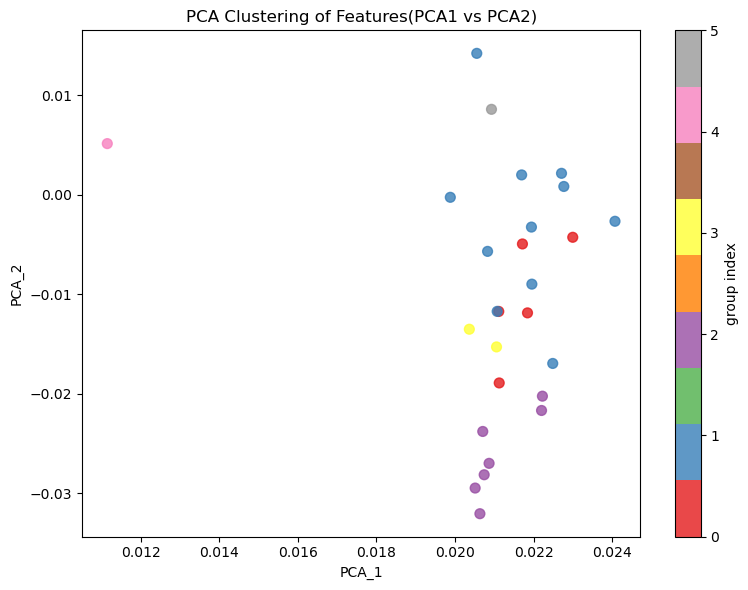

AUDUSD_M1    1
AUS200_M1    0
EURGBP_M1    5
EURJPY_M1    2
EURUSD_M1    1
FRA40_M1     2
GBPUSD_M1    1
GER30_M1     2
HK50_M1      1
JP225_M1     1
NDX100_M1    2
NTH25_M1     0
NZDUSD_M1    1
SPX500_M1    0
SWI20_M1     0
UK100_M1     1
UKOUSD_M1    2
US2000_M1    1
US30_M1      0
USDCAD_M1    1
USDCHF_M1    3
USDJPY_M1    2
USOUSD_M1    2
VIX_M1       4
XAGUSD_M1    1
XAUUSD_M1    1
XPTUSD_M1    3
Name: cluster, dtype: int32

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=best_k, random_state=0)
labels = kmeans.fit_predict(loadings_df)
loadings_df['cluster'] = labels


plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    loadings_df.iloc[:,0],          # 第一主成分值
    loadings_df.iloc[:,1],      # 第二主成分值
    c=loadings_df["cluster"],    # 以群組編號上色
    cmap="Set1",
    s=50,
    alpha=0.8
)

plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.title("PCA Clustering of Features(PCA1 vs PCA2)")
plt.colorbar(scatter, label="group index")

plt.tight_layout()
plt.show()

loadings_df['cluster'].to_csv('results/clusters.csv')
loadings_df['cluster']